# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini


In [ ]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc.git src

Cloning into 'src'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (357/357), done.
remote: Total 401 (delta 226), reused 198 (delta 32), pack-reused 0
Receiving objects: 100% (401/401), 12.98 MiB | 31.41 MiB/s, done.
Resolving deltas: 100% (226/226), done.


In [ ]:
!pip install efficientnet-pytorch albumentations

In [ ]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('src/')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

## Parameters

In [ ]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

## Initialization

In [ ]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [ ]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("src/blazeface/blazeface.pth")
facedet.load_anchors("src/blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

## Detect faces

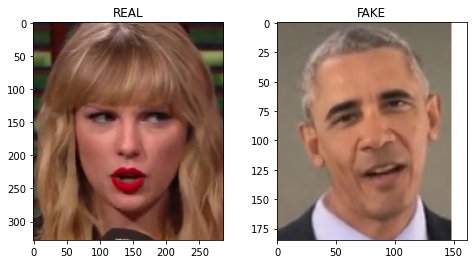

In [ ]:
vid_real_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/taylorobama_real.mp4')
vid_fake_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/taylorobama_fake.mp4')

im_real_face = vid_real_faces[10]['faces'][0]
im_fake_face = vid_fake_faces[10]['faces'][1]

fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

## Predict scores for each frame

In [ ]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][1])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


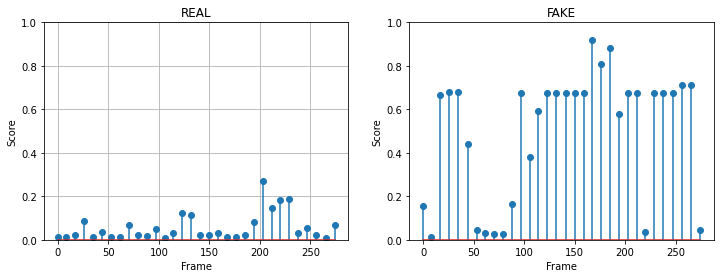

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.0345
Average score for FAKE face: 0.4847


## Test the model with deepfake videos we generated in the previous lab

**Copy this folder (or add a shortcut) https://drive.google.com/drive/folders/1g5k4vLKlfmbB7MGA3TX1TBep9zGvJudg?usp=sharing to your google drive (the same folder as last week).**

**Mount your Google drive folder on Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

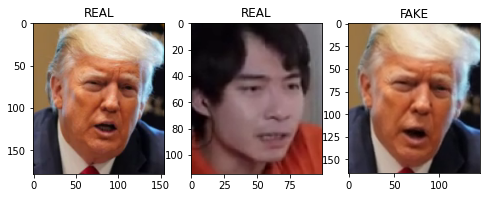

In [ ]:
vid_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/rogertrump.mp4')

im_face = vid_faces[30]['faces'][2]
im_real_face = vid_faces[30]['faces'][1]
im_fake_face = vid_faces[30]['faces'][0]

fig,ax = plt.subplots(1,3,figsize=(8,4))

ax[0].imshow(im_face)
ax[0].set_title('REAL')

ax[1].imshow(im_real_face)
ax[1].set_title('REAL')

ax[2].imshow(im_fake_face)
ax[2].set_title('FAKE');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


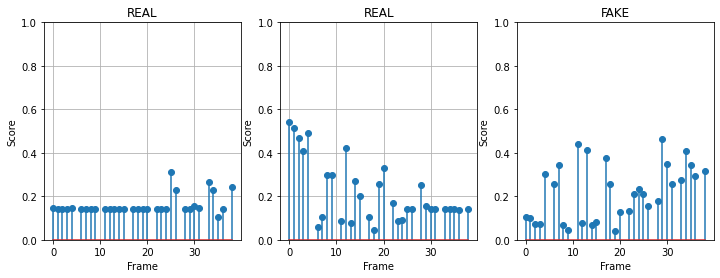

In [ ]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_t = torch.stack( [ transf(image=frame['faces'][2])['image'] for frame in vid_faces if len(frame['faces'])] )
faces_real_t = torch.stack( [ transf(image=frame['faces'][1])['image'] for frame in vid_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_faces if len(f['faces'])],expit(faces_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[1].set_title('REAL')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].grid(True)

ax[2].stem([f['frame_idx'] for f in vid_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[2].set_title('FAKE')
ax[2].set_xlabel('Frame')
ax[2].set_ylabel('Score')
ax[2].set_ylim([0,1])
ax[2].set_yticks([0,1],['REAL','FAKE']);

In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_pred.mean())))
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.1552
Average score for REAL video: 0.1874
Average score for FAKE face: 0.1881


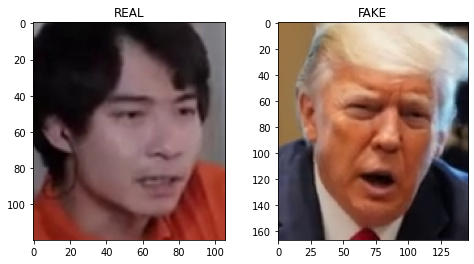

In [ ]:
vid_real_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/rogertrump_real.mp4')
vid_fake_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/rogertrump_fake.mp4')

im_real_face = vid_real_faces[30]['faces'][0]
im_fake_face = vid_fake_faces[30]['faces'][0]

fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


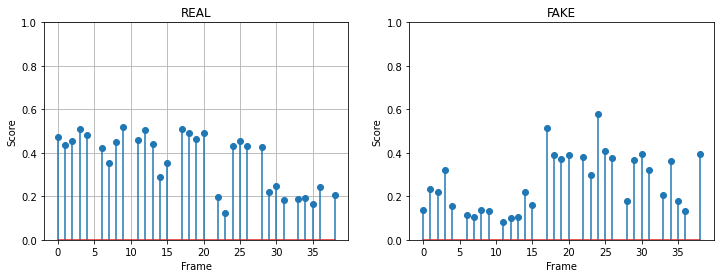

In [ ]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.3560
Average score for FAKE face: 0.2417


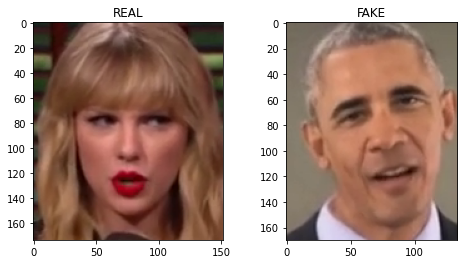

In [ ]:
vid_real_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/taylorobama_real.mp4')
vid_fake_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/taylorobama_fake.mp4')

im_real_face = vid_real_faces[10]['faces'][0]
im_fake_face = vid_fake_faces[10]['faces'][0]

fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


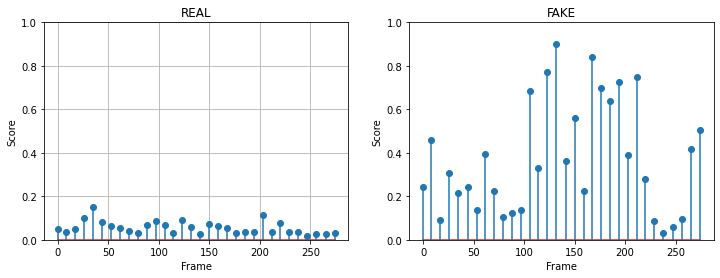

In [ ]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.0493
Average score for FAKE face: 0.3360


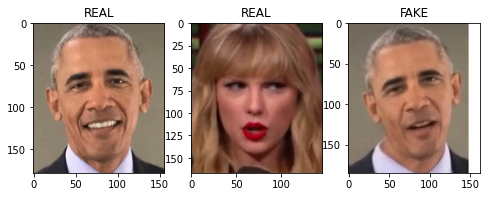

In [ ]:
vid_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/taylorobama.mp4')

im_face = vid_faces[10]['faces'][0] # extract list of faces in frame 10th of the video. Get the first face
im_real_face = vid_faces[10]['faces'][2] # extract list of faces in frame 10th of the video. Get the third face
im_fake_face = vid_faces[10]['faces'][1] # extract list of faces in frame 10th of the video. Get the second face

fig,ax = plt.subplots(1,3,figsize=(8,4))

ax[0].imshow(im_face)
ax[0].set_title('REAL')

ax[1].imshow(im_real_face)
ax[1].set_title('REAL')

ax[2].imshow(im_fake_face)
ax[2].set_title('FAKE');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


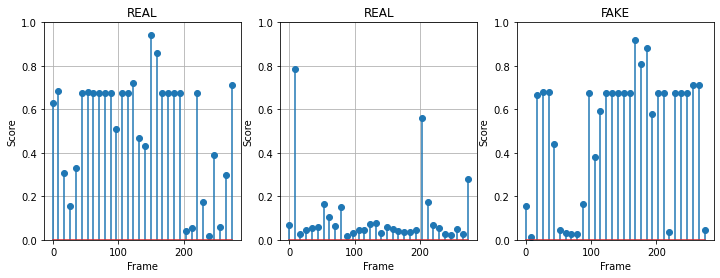

In [ ]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_faces if len(frame['faces'])] )
faces_real_t = torch.stack( [ transf(image=frame['faces'][2])['image'] for frame in vid_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][1])['image'] for frame in vid_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_faces if len(f['faces'])],expit(faces_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[1].set_title('REAL')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].grid(True)

ax[2].stem([f['frame_idx'] for f in vid_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[2].set_title('FAKE')
ax[2].set_xlabel('Frame')
ax[2].set_ylabel('Score')
ax[2].set_ylim([0,1])
ax[2].set_yticks([0,1],['REAL','FAKE']);

In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_pred.mean())))
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.4847
Average score for REAL video: 0.0678
Average score for FAKE face: 0.4252


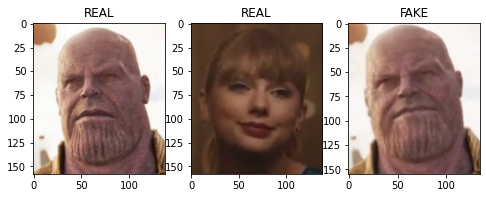

In [ ]:
vid_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/taylorthanos.mp4')

im_face = vid_faces[10]['faces'][0]
im_real_face = vid_faces[10]['faces'][1]
im_fake_face = vid_faces[10]['faces'][2]

fig,ax = plt.subplots(1,3,figsize=(8,4))

ax[0].imshow(im_face)
ax[0].set_title('REAL')

ax[1].imshow(im_real_face)
ax[1].set_title('REAL')

ax[2].imshow(im_fake_face)
ax[2].set_title('FAKE');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


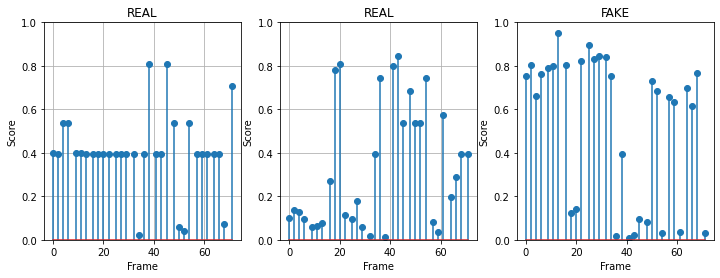

In [ ]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_faces if len(frame['faces'])] )
faces_real_t = torch.stack( [ transf(image=frame['faces'][1])['image'] for frame in vid_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][2])['image'] for frame in vid_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_faces if len(f['faces'])],expit(faces_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[1].set_title('REAL')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].grid(True)

ax[2].stem([f['frame_idx'] for f in vid_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[2].set_title('FAKE')
ax[2].set_xlabel('Frame')
ax[2].set_ylabel('Score')
ax[2].set_ylim([0,1])
ax[2].set_yticks([0,1],['REAL','FAKE']);

In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_pred.mean())))
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.3711
Average score for REAL video: 0.2587
Average score for FAKE face: 0.4615


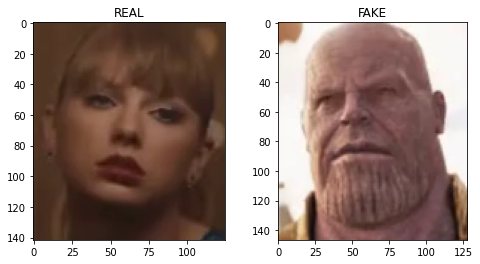

In [ ]:
vid_real_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/taylorthanos_real.mp4')
vid_fake_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/taylorthanos_fake.mp4')

im_real_face = vid_real_faces[0]['faces'][0]
im_fake_face = vid_fake_faces[0]['faces'][0]

fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


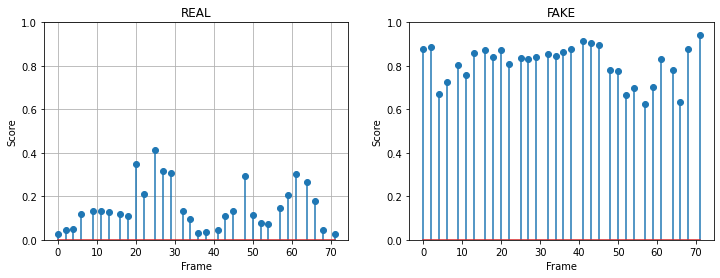

In [ ]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.1186
Average score for FAKE face: 0.8243


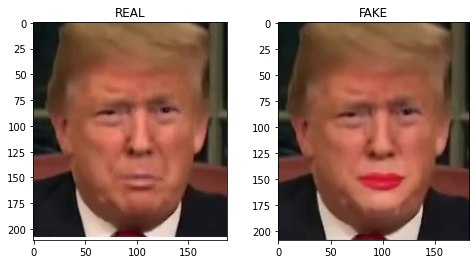

In [ ]:
vid_real_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/trumpswap_real.mp4')
vid_fake_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/trumpswap_fake.mp4')

im_real_face = vid_real_faces[0]['faces'][0]
im_fake_face = vid_fake_faces[0]['faces'][0]

fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


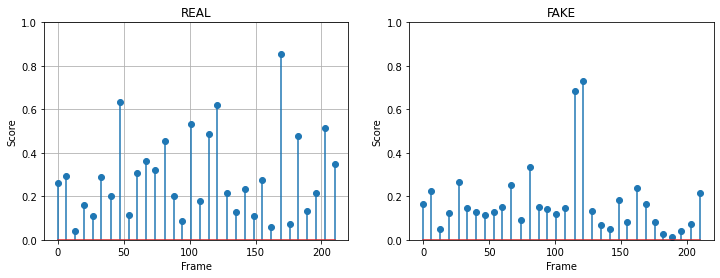

In [ ]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.2545
Average score for FAKE face: 0.1356


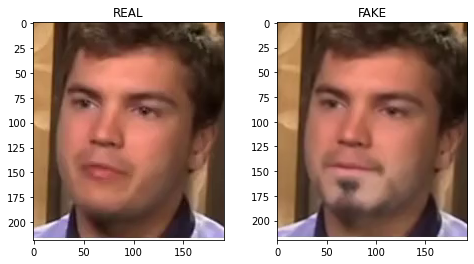

In [ ]:
vid_real_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/beardswap_real.mp4')
vid_fake_faces = face_extractor.process_video('/content/gdrive/My Drive/3183_lab3/output/beardswap_fake.mp4')

im_real_face = vid_real_faces[0]['faces'][0]
im_fake_face = vid_fake_faces[0]['faces'][0]

fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


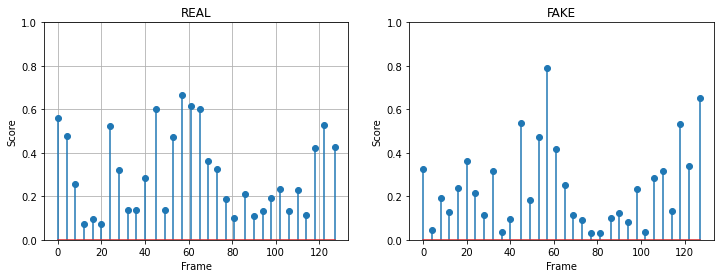

In [ ]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.2690
Average score for FAKE face: 0.1928
